# BigData Analytics Course Project 
## Project Topic: Apply ML Algorithms to Dataset
### Aim: To recognize Handwriting using CNN + RNN with Keras and TensorFlow package
Presented by,   
Name:        Surya Narayanan S  
Reg No:      121015098  
Year & Dept: 4 IT  

* Dataset: https://www.kaggle.com/landlord/handwriting-recognition
* Dataset size: 1.3 GB
* No of Images: 3.72 Lakhs
* A CRNN (Convolutional + Recurrent Neural Network) Machine Learning Model is built to recognize and convert Handwritten Images to text using TensorFlow and Keras package in python.
* Accuracy, Support, Confusion matrix, Classification Report, Similarity Histogram are used for evaluation.

In [1]:
#Basic Imports
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
import pylab as pl


In [2]:
#Tech Stack
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from Levenshtein import jaro_winkler

In [3]:
os.chdir('C:\\Users\\surya\\Documents\\Lab\\Python\\BigDataProject')

train = pd.read_csv("HandwrittenDataset/written_name_train_v2.csv")
valid = pd.read_csv("HandwrittenDataset/written_name_validation_v2.csv")

display(train.describe(include="all"))
display(train.head())

,FILENAME,IDENTITY
count,330961,330396
unique,330961,100539
top,TRAIN_161771.jpg,THOMAS
freq,1,1825


,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [4]:

print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)


Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


Sample Images


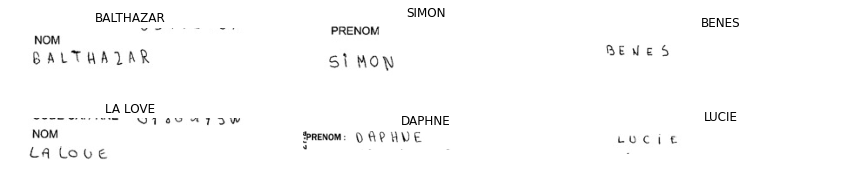

In [5]:
#Sample Images
plt.figure(figsize=(15, 10))
print("Sample Images")
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'HandwrittenDataset/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)


No of Unreadable Images 102
Sample Unreadable Images


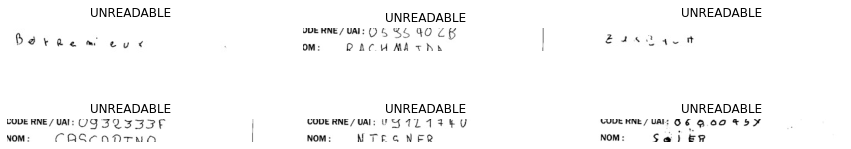

After Cleaning
Length of Train Dataset  330294
Length of Validation Dataset  41280


In [6]:
#Remove Unreadable
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)
print("No of Unreadable Images " + str(len(unreadable)))
print("Sample Unreadable Images")
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'HandwrittenDataset/train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)
plt.show()

train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

#Convert all Characters to Upper Case

train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()



train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)
print("After Cleaning")
print("Length of Train Dataset ", len(train))
print("Length of Validation Dataset ", len(valid))

In [7]:
#Image Preprocessing
def preprocess(img):
    
    
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV) 
    #rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18, 18)) 
    #dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1) 
    #display(Image.fromarray(thresh1))
    (h, w) = img.shape
    final_img = np.ones([64, 256])*0 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    final_img = final_img.astype("uint8")
    #display(Image.fromarray(final_img))
    final_img = cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)
    #display(Image.fromarray(final_img))
    return final_img


Image Before Pre-Processing


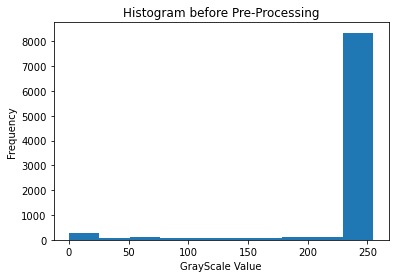

Image after Pre-Processing


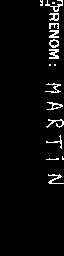

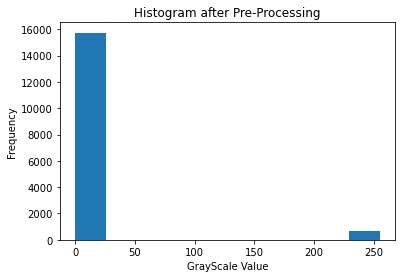

In [8]:
#Histogram of sample Image before preprocessing
fle = "HandwrittenDataset/test_v2/test/TEST_0006.jpg"
#fle = "HandwrittenDataset/Hello.jpg"
#fle = "HandwrittenDataset/Chandra1.jpg"
img = cv2.imread(fle, cv2.IMREAD_GRAYSCALE)
print("Image Before Pre-Processing")
display(Image.fromarray(img))
img2 = img.flatten()
plt.hist(img2)
plt.title("Histogram before Pre-Processing")
plt.xlabel("GrayScale Value")
plt.ylabel("Frequency")
plt.show()

processed = preprocess(img)
print("Image after Pre-Processing")
display(Image.fromarray(processed))
img2 = processed.flatten()
plt.hist(img2)
plt.title("Histogram after Pre-Processing")
plt.xlabel("GrayScale Value")
plt.ylabel("Frequency")
plt.show()

In [9]:
#Read Train Images from a folder and preprocess it using OpenCV

train_size = 30000
train_x = []

for i in range(train_size):
    img_dir = 'HandwrittenDataset/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)
train_x = np.array(train_x).reshape(-1, 256, 64, 1)

In [12]:
print("Train Images Size ", train_x.shape)

Train Imagae Size  (30000, 256, 64, 1)


In [13]:
#Read Validation Images from a folder and preprocess it using OpenCV

valid_x = []
valid_size= 3000
start_ind = 0
for i in range(start_ind,start_ind+valid_size):
    img_dir = 'HandwrittenDataset/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)
print("Validation Images Size ",valid_x.shape)

Validation Images Size  (3000, 256, 64, 1)


In [14]:
# Map characters to a specific number from 0 to 26
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels

#Convert a given label to its corresponding Number
def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

#Convert given number list to its corresponding String
def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret



name = 'JEBASTIN'
num_list = label_to_num(name)
print("Name to Number List")
print(name, ' to ',label_to_num(name))

print("Number List to name")
print(num_list," to ",num_to_label(num_list))

Name to Number List
JEBASTIN  to  [ 9  4  1  0 18 19  8 13]
Number List to name
[ 9  4  1  0 18 19  8 13]  to  JEBASTIN


In [15]:
#Create Input matrix to give it to the Model
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])    
    
    

print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], '\ntrain_input_len : ', train_input_len[100])


True label :  NOUR 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [4.] 
train_input_len :  [62.]


In [16]:
#Create validation matrix to give it to the model for learning
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(start_ind,start_ind + valid_size):
    valid_label_len[i-start_ind] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i-start_ind, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])    

print('True label : ',valid.loc[100, 'IDENTITY'] , '\nvalid_y : ',valid_y[100],'\nvalid_label_len : ',valid_label_len[100], '\nvalid_input_len : ', valid_input_len[100])


True label :  CLOE 
valid_y :  [ 2. 11. 14.  4. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
valid_label_len :  [4.] 
valid_input_len :  [62.]


In [17]:
#Construct the CRNN model

#https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53


input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
#https://colah.github.io/posts/2015-08-Understanding-LSTMs/
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 64, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 64, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 64, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 256, 64, 32)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 128, 32, 32)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 32, 64)       18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 32, 64)       256   

In [18]:
# the ctc loss function
#https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


In [19]:
#Compile the built model with Adam Optimizer and CTC Loss function

labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)


# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))
model_final.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 64, 1)] 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 64, 32)  320         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 64, 32)  128         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 64, 32)  0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [ ]:
#Fit (Train) the model with Train dataset and validation dataset
#model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output,  validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output), epochs=60, batch_size=128)
#model.save("tfmodelforhandwriting2")

In [3]:
#To Load the saved Model
model = tf.keras.models.load_model("tfmodelforhandwriting2")

In [22]:
#Predict handwritten Images
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

In [23]:
#To Find Accuracy of Predicted Characters and Predicted Word
y_true = valid.loc[0:valid_size-1, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0
y_true_char = []
y_pred_char = []
for i in range(len(y_true)):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
        y_true_char.append(tr[j])
        y_pred_char.append(pr[j])
            
    if pr == tr :
        correct += 1 
print("No of Images " + str(len(y_true)))
print("No of Characters over all Images " + str(len(y_true_char)))    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/len(y_true)))

No of Images 3000
No of Characters over all Images 19410
Correct characters predicted : 91.25%
Correct words predicted      : 75.17%


              precision    recall  f1-score   support

                   0.76      0.67      0.71        84
           '       0.00      0.00      0.00         2
           -       0.66      0.75      0.70        51
           A       0.94      0.94      0.94      2433
           B       0.94      0.85      0.90       446
           C       0.92      0.91      0.91       623
           D       0.92      0.88      0.90       588
           E       0.95      0.95      0.95      2399
           F       0.94      0.86      0.90       166
           G       0.90      0.94      0.92       362
           H       0.88      0.86      0.87       513
           I       0.94      0.95      0.94      1587
           J       0.86      0.90      0.88       140
           K       0.85      0.80      0.82       119
           L       0.95      0.95      0.95      1439
           M       0.90      0.86      0.88       740
           N       0.93      0.94      0.93      1506
           O       0.90    

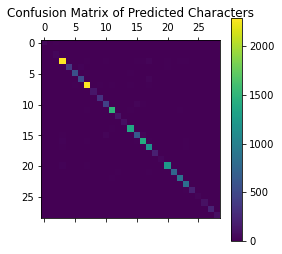

In [24]:
#Classification Report and Confusion Matrix
print(classification_report(y_true_char,y_pred_char))

cm = (confusion_matrix(y_true_char,y_pred_char))
pl.matshow(cm)
pl.title("Confusion Matrix of Predicted Characters")
pl.colorbar()
pl.show()

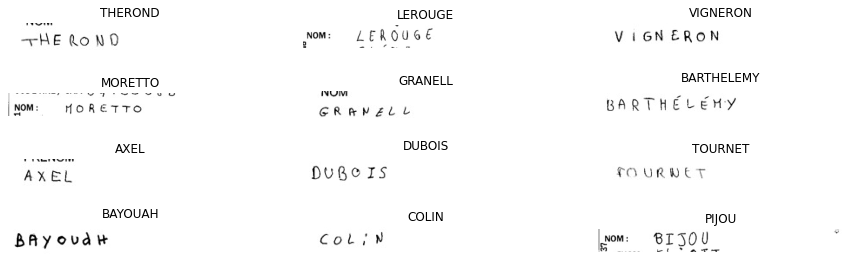

In [25]:
#To test sample Images. To view Sample Images along with predicted Label
#test = pd.read_csv("HandwrittenDataset/written_name_train_v2.csv")
test = pd.read_csv('HandwrittenDataset/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
start_img_ind = 3000
for i in range(start_img_ind,start_img_ind+12):
    ax = plt.subplot(4, 3, i+1-start_img_ind)
    img_dir = 'HandwrittenDataset/test_v2/test/'+test.loc[i, 'FILENAME']
    #img_dir = 'HandwrittenDataset/train_v2/train/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)


In [7]:
#To Load the saved Model
CNNmodel = tf.keras.models.load_model("CNNModel")
print("CNN Model")
print(CNNmodel.summary())
RNNmodel = tf.keras.models.load_model("RNNModel4")
print("RNN Model")
print(RNNmodel.summary())

CNN Model
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 64, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 64, 32)       320       
_________________________________________________________________
batch_normalization_3 (Batch (None, 256, 64, 32)       128       
_________________________________________________________________
activation_3 (Activation)    (None, 256, 64, 32)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 128, 32, 32)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 32, 64)       18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 32, 64) 

In [27]:
valid = pd.read_csv("TrainTable.csv") 
#display(valid.describe(include="all"))
display(valid.head())
display(valid.tail())
print("No of Images Tested with ", len(valid))

,Index,FILENAME,IDENTITY,CRNNPredicted,CNNPredicted,RNNPredicted
0,0,TRAIN_00001.jpg,BALTHAZAR,BALTHAZAR,BALTHAZAR,BLALTHAIAR
1,1,TRAIN_00002.jpg,SIMON,SIMON,SIMON,BLIMON
2,2,TRAIN_00003.jpg,BENES,BENES,BENES,BVENES
3,3,TRAIN_00004.jpg,LA LOVE,LALOUE,LALOUE,BLALOUE
4,4,TRAIN_00005.jpg,DAPHNE,DAPHNE,DAPHNE,CMAPHNE


,Index,FILENAME,IDENTITY,CRNNPredicted,CNNPredicted,RNNPredicted
330287,330287,TRAIN_330957.jpg,LENNY,LENNY,LENNY,BLENNY
330288,330288,TRAIN_330958.jpg,TIFFANY,TIFFANY,TIEEANY,BLIEFANY
330289,330289,TRAIN_330959.jpg,COUTINHO DESA,COUTINHO DESA,COUTINHODESA,BCOUTINO DEA
330290,330290,TRAIN_330960.jpg,MOURAD,MOURAD,AOURAD,BAOURAD
330291,330291,TRAIN_330961.jpg,HELOISE,HELOISE,HELOISE,BLELOISE


No of Images Tested with  330292


Prediction Result for  CRNNPredicted
No of Images 330292
No of Characters over all Images 2134794
Correct characters predicted : 92.98%
Correct words predicted      : 75.56%
Classification Report: CRNNPredicted
              precision    recall  f1-score   support

                   0.76      0.63      0.69     10100
           #       0.00      0.00      0.00         1
           '       0.61      0.22      0.32       230
           -       0.66      0.72      0.69      6493
           ?       0.00      0.00      0.00         0
           A       0.95      0.95      0.95    266969
           B       0.93      0.88      0.91     45635
           C       0.91      0.93      0.92     67581
           D       0.91      0.89      0.90     59587
           E       0.95      0.95      0.95    266368
           F       0.93      0.88      0.90     18135
           G       0.90      0.90      0.90     38807
           H       0.90      0.89      0.89     61233
           I       0.95      0.9

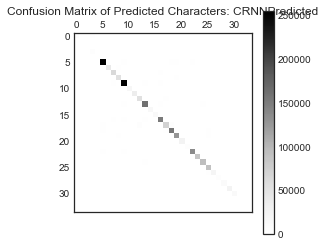

Mean Squared Error:  CRNNPredicted   10.64500509182619
Similarity Score between True Label and Predicted Label: CRNNPredicted


,CRNNPredicted,IDENTITY,SIMILARITY_SCORE
0,BALTHAZAR,BALTHAZAR,1.000000
1,SIMON,SIMON,1.000000
2,BENES,BENES,1.000000
3,LALOUE,LALOVE,0.933333
4,DAPHNE,DAPHNE,1.000000
5,LUCIE,LUCIE,1.000000
6,NASSIM,NASSIM,1.000000
7,ASSRAOUI,ASSRAOUI,1.000000
8,VLAVIAN,LAVIAN,0.869048
9,MAEVA,MAEVA,1.000000


Histogram of Similarity: CRNNPredicted


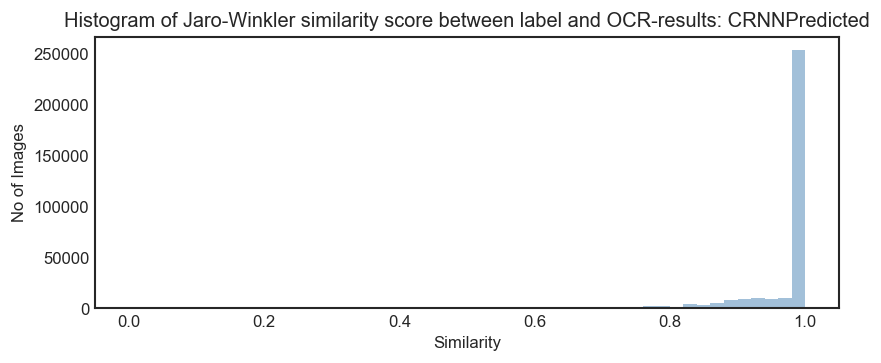

Prediction Result for  CNNPredicted
No of Images 330292
No of Characters over all Images 2092410
Correct characters predicted : 84.17%
Correct words predicted      : 59.54%
Classification Report: CNNPredicted
              precision    recall  f1-score   support

                   0.01      0.00      0.00      9879
           #       0.00      0.00      0.00         1
           '       0.00      0.00      0.00       217
           -       0.58      0.51      0.54      6425
           A       0.86      0.88      0.87    262530
           B       0.85      0.82      0.83     45333
           C       0.83      0.84      0.84     66690
           D       0.83      0.77      0.80     58250
           E       0.87      0.88      0.88    258692
           F       0.82      0.79      0.81     17895
           G       0.85      0.81      0.83     38471
           H       0.77      0.79      0.78     60474
           I       0.84      0.85      0.85    168685
           J       0.86      0.75 

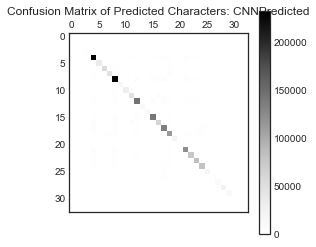

Mean Squared Error:  CNNPredicted   26.272270730879704
Similarity Score between True Label and Predicted Label: CNNPredicted


,CNNPredicted,IDENTITY,SIMILARITY_SCORE
0,BALTHAZAR,BALTHAZAR,1.000000
1,SIMON,SIMON,1.000000
2,BENES,BENES,1.000000
3,LALOUE,LALOVE,0.933333
4,DAPHNE,DAPHNE,1.000000
5,LUCIE,LUCIE,1.000000
6,NASSIM,NASSIM,1.000000
7,ASSRAOUI,ASSRAOUI,1.000000
8,MLAVIAN,LAVIAN,0.952381
9,MAEVA,MAEVA,1.000000


Histogram of Similarity: CNNPredicted


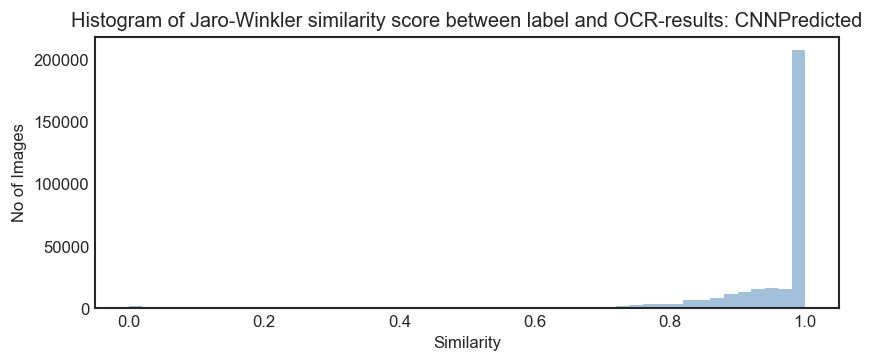

Prediction Result for  RNNPredicted
No of Images 330292
No of Characters over all Images 2144334
Correct characters predicted : 69.81%
Correct words predicted      : 0.26%
Classification Report: RNNPredicted
              precision    recall  f1-score   support

                   0.56      0.42      0.48      9877
           #       0.00      0.00      0.00         1
           '       0.45      0.10      0.16       216
           -       0.40      0.44      0.42      6474
           ?       0.00      0.00      0.00         1
           A       0.84      0.77      0.81    266860
           B       0.12      0.72      0.20     45613
           C       0.52      0.45      0.48     67799
           D       0.73      0.48      0.58     60078
           E       0.87      0.82      0.85    268372
           F       0.24      0.33      0.28     18198
           G       0.64      0.37      0.47     38919
           H       0.73      0.63      0.67     61191
           I       0.87      0.85  

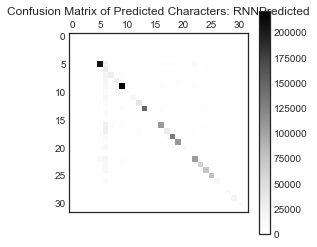

Mean Squared Error:  RNNPredicted   41.535935166816365
Similarity Score between True Label and Predicted Label: RNNPredicted


,RNNPredicted,IDENTITY,SIMILARITY_SCORE
0,BLALTHAIAR,BALTHAZAR,0.869167
1,BLIMON,SIMON,0.822222
2,BVENES,BENES,0.950000
3,BLALOUE,LALOVE,0.849206
4,CMAPHNE,DAPHNE,0.849206
5,BLUCIE,LUCIE,0.944444
6,BCMASSIM,NASSIM,0.652778
7,TFBSSRAOUI,ASSRAOUI,0.858333
8,BALAVRAN,LAVIAN,0.686111
9,BLAEVA,MAEVA,0.822222


Histogram of Similarity: RNNPredicted


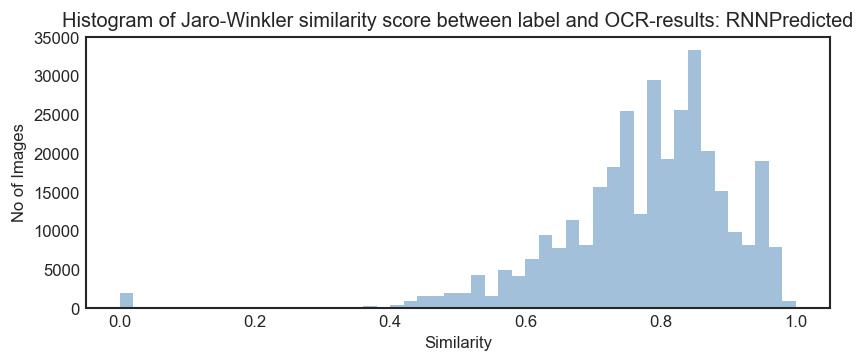

In [30]:
col_names = ["CRNNPredicted","CNNPredicted","RNNPredicted"]

for mod in col_names:
    print("Prediction Result for ",mod)
    prediction = valid[mod]
    y_true = valid['IDENTITY']
    correct_char = 0
    total_char = 0
    correct = 0
    y_true_char = []
    y_pred_char = []
    for i in range(len(y_true)):
        pr = str(prediction[i])
        tr = y_true[i]
        total_char += min(len(tr), len(pr))
        #print(tr,pr)
        for j in range(min(len(tr), len(pr))):
            if mod == "RNNPredicted":
                if tr[-j] == pr[-j]:
                    correct_char += 1
                y_true_char.append(tr[-j])
                y_pred_char.append(pr[-j])
            else:
                if tr[j] == pr[j]:
                    correct_char += 1
                y_true_char.append(tr[j])
                y_pred_char.append(pr[j])

        if pr == tr :
            correct += 1 

    print("No of Images " + str(len(y_true)))
    print("No of Characters over all Images " + str(len(y_true_char)))
    print('Correct characters predicted : %.2f%%' %(correct_char*100/len(y_true_char)))
    print('Correct words predicted      : %.2f%%' %(correct*100/len(y_true)))
    print("Classification Report: " + mod)
    print(classification_report(y_true_char,y_pred_char,zero_division=0))
    print("Confusion Matrix: " + mod)
    cm = (confusion_matrix(y_true_char,y_pred_char))
    pl.matshow(cm)
    pl.title("Confusion Matrix of Predicted Characters: " + mod)
    pl.colorbar()
    pl.show()

    print("Mean Squared Error: ",mod," ",mean_squared_error([ord(i) for i in y_true_char],[ord(i) for i in y_pred_char]))


    clean_result = valid["IDENTITY"]
    validation_df = pd.Series(prediction,name = mod)
    # Create 1 dataframe with both actual and OCR labels
    ocr_vs_actual = pd.merge(validation_df,clean_result,right_index=True,left_index=True)

    # Remove labels which do not exist
    ocr_vs_actual = ocr_vs_actual.loc[ocr_vs_actual[mod].notnull(), :]

    # Remove spaces in OCR output
    ocr_vs_actual['IDENTITY'] = ocr_vs_actual['IDENTITY'].str.replace('\\s', '', regex=True)
    #ocr_vs_actual.head(10)

    # Create jaro-winkler similarity score
    vectorized_jaro_winkler = np.vectorize(jaro_winkler)

    ocr_vs_actual['SIMILARITY_SCORE'] = vectorized_jaro_winkler(ocr_vs_actual[mod].str.upper(), np.where(ocr_vs_actual['IDENTITY'].isnull(), '',  ocr_vs_actual['IDENTITY'].str.upper()))
    print("Similarity Score between True Label and Predicted Label: " + mod)
    display(ocr_vs_actual.head(10))


    
    # Plot histogram of similarity scores to see how well we did
    print("Histogram of Similarity: " + mod)
    plt.style.use('seaborn-white')
    plt.figure(figsize=(8,3), dpi=120)
    plt.hist(ocr_vs_actual['SIMILARITY_SCORE'], bins=50, alpha=0.5, color='steelblue', edgecolor='none')
    plt.title('Histogram of Jaro-Winkler similarity score between label and OCR-results: '+ mod)
    plt.xlabel("Similarity")
    plt.ylabel("No of Images")
    plt.show()